<a href="https://colab.research.google.com/github/lalit-kumr/credit_card_consumption/blob/main/Credit_card-final-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Steps
- Import libs
- Import data
- Clean both sets
- Merge the data sets
- Split data in numerical and categorical
- Outlier removal in both sets
- fill na
- splitting in train and predict
- Label encoding
- Join dataset
- Build model OLS
- Remove features having high p value
- Apply vif
- Drop vif unwanted variables one by one
- Log of y 
- OLS model again
- RFE
- Apply linear reg model





## 0. Importing libs

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Importing Data

In [156]:
# behaviour = pd.read_csv('CustomerBehaviorData.csv')
# consumption = pd.read_csv('CreditConsumptionData.csv')
# customer = pd.read_csv('CustomerDemographics.csv')


behaviour = pd.read_csv('https://github.com/lalit-kumr/credit_card_consumption/blob/main/CustomerBehaviorData.csv?raw=true')
consumption = pd.read_csv('https://github.com/lalit-kumr/credit_card_consumption/raw/main/CreditConsumptionData.csv')
customer = pd.read_csv('https://github.com/lalit-kumr/credit_card_consumption/raw/main/CustomerDemographics.csv')

## 2. Cleaning Data

In [157]:
#finding NaN values in customer df
# customer.isna().sum()
#Droppping observations having NaN values
customer.dropna(inplace=True)
customer.isna().sum()

customer_id                     0
account_type                    0
gender                          0
age                             0
income                          0
emp_tenure_years                0
tenure_with_bank                0
region_code                     0
net_banking_flag                0
avg_days_between_transaction    0
dtype: int64

In [158]:
#Droppping observations having NaN values
behaviour.dropna(inplace=True)
behaviour.isna().sum()

customer_id              0
cc_cons_apr              0
dc_cons_apr              0
cc_cons_may              0
dc_cons_may              0
cc_cons_jun              0
dc_cons_jun              0
cc_count_apr             0
cc_count_may             0
cc_count_jun             0
dc_count_apr             0
dc_count_may             0
dc_count_jun             0
card_lim                 0
personal_loan_active     0
vehicle_loan_active      0
personal_loan_closed     0
vehicle_loan_closed      0
investment_1             0
investment_2             0
investment_3             0
investment_4             0
debit_amount_apr         0
credit_amount_apr        0
debit_count_apr          0
credit_count_apr         0
max_credit_amount_apr    0
debit_amount_may         0
credit_amount_may        0
credit_count_may         0
debit_count_may          0
max_credit_amount_may    0
debit_amount_jun         0
credit_amount_jun        0
credit_count_jun         0
debit_count_jun          0
max_credit_amount_jun    0
l

In [159]:
# checking nan cells in coonsumption
consumption.isna().sum()

customer_id          0
cc_cons_target    5000
dtype: int64

## 3.Merging the data Frames

### 3.1 Merging the dataframes

In [160]:
# - now we will merge all three dataframes on the basis of customer_id.
# - first we will merge customer and behaviour dataframes as customer_be
# - next we will merge the cosumption dataframe with the custoemr_be df and store the resultant dataframe in **final**


customer_behaviour = pd.merge(left=customer, right=behaviour, on='customer_id')
final = pd.merge(left=customer_behaviour, right=consumption, on='customer_id')

#dropping customer id
final.drop(labels='customer_id',axis=1,inplace=True)

## 4\. Splitting data into numerical and categorical

In [161]:
#extracting numerical columns from the dataset
num_cols = final.columns.difference(['account_type', 'gender', 'income', 'loan_enq'])
num_cols = final[num_cols]
num_cols.columns

Index(['age', 'avg_days_between_transaction', 'card_lim', 'cc_cons_apr',
       'cc_cons_jun', 'cc_cons_may', 'cc_cons_target', 'cc_count_apr',
       'cc_count_jun', 'cc_count_may', 'credit_amount_apr',
       'credit_amount_jun', 'credit_amount_may', 'credit_count_apr',
       'credit_count_jun', 'credit_count_may', 'dc_cons_apr', 'dc_cons_jun',
       'dc_cons_may', 'dc_count_apr', 'dc_count_jun', 'dc_count_may',
       'debit_amount_apr', 'debit_amount_jun', 'debit_amount_may',
       'debit_count_apr', 'debit_count_jun', 'debit_count_may', 'emi_active',
       'emp_tenure_years', 'investment_1', 'investment_2', 'investment_3',
       'investment_4', 'max_credit_amount_apr', 'max_credit_amount_jun',
       'max_credit_amount_may', 'net_banking_flag', 'personal_loan_active',
       'personal_loan_closed', 'region_code', 'tenure_with_bank',
       'vehicle_loan_active', 'vehicle_loan_closed'],
      dtype='object')

In [162]:
#extracting categorical columns from the data
cat_cols = final.select_dtypes(include=['O'])
cat_cols.columns

Index(['account_type', 'gender', 'income', 'loan_enq'], dtype='object')

## 6\. label encoding of cat cols

In [163]:
cat_cols = pd.get_dummies(cat_cols)
cat_cols.drop(labels=['account_type_saving','gender_F','income_HIGH'],axis=1,inplace=True)
#renaming columns
cat_cols.columns = ['account_type','gender','income_low','income_medium', 'loan_enq']
cat_cols.head(3)

account_type  gender  income_low  income_medium  loan_enq
0             1       1           0              1         1
1             1       1           0              1         1
2             1       0           0              1         1

###  Joining cat_cols and num_cols

In [164]:
# joining the num_cols and cat_cols df 
df = pd.concat([num_cols,cat_cols],axis=1)
df.head(3)

age  avg_days_between_transaction  ...  income_medium  loan_enq
0   63                           5.0  ...              1         1
1   36                          12.0  ...              1         1
2   28                          13.0  ...              1         1

[3 rows x 49 columns]

## Pandas profiling

In [165]:
# import pandas_profiling

# profile_report=pandas_profiling.ProfileReport(df)
# profile_report.to_file("profile_report.html")

## Splitting the data in df_train and df_predict

In [166]:
#now we will split the df in two parts. df_predict and df_train.
#df_train will contain entries having numerial values in cc_cons_target
#df_predict will have the rows/customers that we have to predict the output for

#filtering all the rows from final that contain NaN values in cc_cons_target and storing those rows in df_predict.
df_predict = df[df.cc_cons_target.isna()]
#dropping the NaN values of cc_cons_target 
df_predict.drop(labels='cc_cons_target',axis=1,inplace=True)

# droppping  all the rows that are in the df_predict dataframe and storing the result in df_train
df_train = df.drop(df_predict.index)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [167]:
df_train.shape

(14995, 49)

In [168]:
df_predict.shape

(4993, 48)

## 5\. Outlier removal from df_train and df_predict

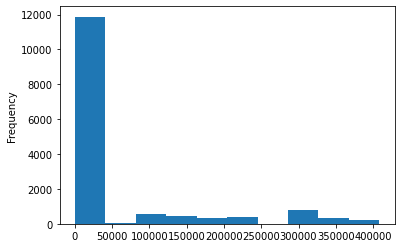

In [169]:
df_train.cc_cons_target.plot(kind='hist')

In [170]:
#As our target variable(cc_cons_target) is non_normalized, we will first drop the observations that do not have 
#values of target variable within 90%ile and 10%ile.
q_low = df_train['cc_cons_target'].quantile(0.10)
q_hi  = df_train['cc_cons_target'].quantile(0.90)

df_train = df_train[(df_train['cc_cons_target'] < q_hi) & (df_train['cc_cons_target'] > q_low)]


#Now we will treat outliers in all other columns
from scipy.stats import mstats

for x in df_train:
  df_train.loc[:,x] = mstats.winsorize(df_train[x], limits=[0.10, 0.10])
df_train.describe()


age  avg_days_between_transaction  ...  income_medium  loan_enq
count  11995.000000                  11995.000000  ...   11995.000000   11995.0
mean      43.430179                     11.043852  ...       0.639850       1.0
std       12.183941                      5.336914  ...       0.480064       0.0
min       29.000000                      3.000000  ...       0.000000       1.0
25%       33.000000                      6.000000  ...       0.000000       1.0
50%       40.000000                     11.000000  ...       1.000000       1.0
75%       53.000000                     16.000000  ...       1.000000       1.0
max       64.000000                     19.000000  ...       1.000000       1.0

[8 rows x 49 columns]

In [171]:
#taking the same steps for df_predict
for x in df_predict:
  df_predict.loc[:,x] = mstats.winsorize(df_predict[x], limits=[0.10, 0.10])
df_predict.describe()


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


age  avg_days_between_transaction  ...  income_medium  loan_enq
count  4993.000000                   4993.000000  ...    4993.000000    4993.0
mean     43.266773                     10.929501  ...       0.632686       1.0
std      12.265384                      5.140595  ...       0.482121       0.0
min      29.000000                      3.000000  ...       0.000000       1.0
25%      33.000000                      6.000000  ...       0.000000       1.0
50%      39.000000                     11.000000  ...       1.000000       1.0
75%      53.000000                     16.000000  ...       1.000000       1.0
max      64.000000                     18.000000  ...       1.000000       1.0

[8 rows x 48 columns]

## 8. Splitting df_train in df_train_x and df_train_y

In [172]:
#As df_train is the data that our model will train on, we will split it into featuers (df_train_x) and target(df_train_y)
df_train_x = df_train[df_train.columns.difference(['cc_cons_target'])]

#df_train_y
df_train_y = df_train[['cc_cons_target']]
df_train_y.columns=['target']

### Normalizing target variable
our target variable should be normalized. Thus we will log transform  our train_y

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


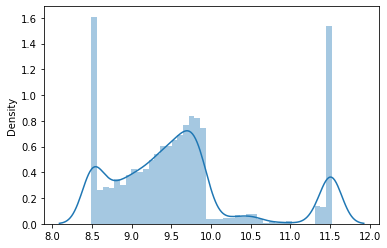

In [173]:
# taking log of df_train_y and plotting histogram
df_train_y_log = np.log(df_train_y)
sns.distplot(df_train_y_log)

In [174]:
# from sklearn.preprocessing import StandardScaler

# std_scaler = StandardScaler()
# aa = std_scaler.fit_transform(df_train_y)

# # sns.distplot(aa)
# sns.distplot(aa)

## 9\. Running OLS model on our dataset with all features

In [175]:
### OLS regression
import statsmodels.api as sm

model = sm.OLS(df_train_y,df_train_x)

model_fit = model.fit()

print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7702
Date:                Sun, 05 Sep 2021   Prob (F-statistic):              0.861
Time:                        18:28:28   Log-Likelihood:            -1.4055e+05
No. Observations:               11995   AIC:                         2.812e+05
Df Residuals:                   11951   BIC:                         2.815e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
account_type    

#### Result of OLS regression model
We can see from the above summary that many of the features have a p-value greter than that of 0.05. 

Thus we will remove those features from our model and rerun the OLS model

In [176]:
#removing the top 5 features on the basis of p_value
remove_cols = ['dc_count','Total_debit_amount','net_banking_flag','age','gender']
new_cols = df_train_x.columns.difference(remove_cols)
df_train_x = df_train_x[new_cols]


## VIF
- VIF is used to remove multicollinearity from the dataset. 
- VIF = 1/(1-R^2)

- It computes the R-sq value for every feature against all other features. The more a feature is collinear with other features , more the VIF score is.
- VIF starts at 1 and has no upper limit
- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In [177]:
#R^2 value is determined to find out how well an independent variable is described by the other independent variables. 
#A high value of R^2 means that the variable is highly correlated with the other variables.
#So, the closer the R^2 value to 1, the higher the value of VIF and
# the higher the multicollinearity with the particular independent variable.


# vif = 1/(1-r^2)


# VIF starts at 1 and has no upper limit
# VIF = 1, no correlation between the independent variable and the other variables
# VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others




# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)


X = df_train_x
calc_vif(X)



#Fixing Multicollinearity

# #Dropping one of the correlated features will help in bringing down the multicollinearity between correlated features:
# X = df.drop(['Age','Salary'],axis=1)
# calc_vif(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


variables       VIF
0                   account_type  1.002300
1   avg_days_between_transaction  1.003494
2                       card_lim  1.002805
3                    cc_cons_apr  1.004466
4                    cc_cons_jun  1.004309
5                    cc_cons_may  1.004446
6                   cc_count_apr  1.002893
7                   cc_count_jun  1.003859
8                   cc_count_may  1.003221
9              credit_amount_apr  1.002050
10             credit_amount_jun  1.002792
11             credit_amount_may  1.002766
12              credit_count_apr  1.003006
13              credit_count_jun  1.003564
14              credit_count_may  1.002363
15                   dc_cons_apr  1.002539
16                   dc_cons_jun  1.002049
17                   dc_cons_may  1.003351
18                  dc_count_apr  1.004109
19                  dc_count_jun  1.003592
20                  dc_count_may  1.003470
21              debit_amount_apr  1.003045
22              debit_amount_jun  1.003772
23              debit_amount_may  1.003563
24               debit_count_apr  1.002961
25               debit_count_jun  1.003609
26               debit_count_may  1.003273
27                    emi_active  1.003812
28              emp_tenure_years  1.002613
29                    income_low  3.235953
30                 income_medium  3.234599
31                  investment_1  1.001857
32                  investment_2  1.003412
33                  investment_3  1.002772
34                  investment_4  1.003845
35                      loan_enq  0.000000
36         max_credit_amount_apr  1.002950
37         max_credit_amount_jun  1.002705
38         max_credit_amount_may  1.002325
39          personal_loan_active  0.000000
40          personal_loan_closed  0.000000
41                   region_code  1.003252
42              tenure_with_bank  1.004546
43           vehicle_loan_active  0.000000
44           vehicle_loan_closed  0.000000

### RFE

In [178]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE


dt_reg = DecisionTreeRegressor(random_state=0)

# lr = LinearRegression()
rfe = RFE(estimator=dt_reg, n_features_to_select=30)
rfe.fit(df_train_x, df_train_y.target)

rfe.ranking_


# selecting features given by RFE
f = rfe.get_support(1) #the most important features
selected_x = df_train_x[df_train_x.columns[f]] # final features`
selected_x.columns

Index(['avg_days_between_transaction', 'card_lim', 'cc_cons_apr',
       'cc_cons_jun', 'cc_cons_may', 'cc_count_may', 'credit_amount_apr',
       'credit_amount_jun', 'credit_amount_may', 'credit_count_jun',
       'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'dc_count_apr',
       'dc_count_jun', 'debit_amount_apr', 'debit_amount_jun',
       'debit_amount_may', 'debit_count_apr', 'debit_count_jun', 'emi_active',
       'emp_tenure_years', 'investment_1', 'investment_2', 'investment_3',
       'investment_4', 'max_credit_amount_apr', 'max_credit_amount_jun',
       'max_credit_amount_may', 'region_code'],
      dtype='object')

### Fitting the selected_x from RFE and df_train_y_log in OLS and creating a model

In [179]:
model = sm.OLS(df_train_y_log,selected_x)

model_fit = model.fit()

print(model_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                          1.466e+04
Date:                Sun, 05 Sep 2021   Prob (F-statistic):                        0.00
Time:                        18:28:39   Log-Likelihood:                         -22426.
No. Observations:               11995   AIC:                                  4.491e+04
Df Residuals:                   11965   BIC:                                  4.513e+04
Df Model:                          30                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

### Predicting OLS regression values

In [180]:
#predicting values for df_train_x 
train_y_log_hat = model_fit.predict(selected_x)

# renmaing columns
train_y_log_hat.columns = ['target']

# taking exp of the values because we transformed the variable in log
train_y_hat = np.exp(train_y_log_hat)
train_y_hat = pd.DataFrame(train_y_hat)
# train_y_hat = train_y_hat.apply(lambda x: '%.5f' % x, axis=1)
# train_y_hat = pd.DataFrame(train_y_hat)
train_y_hat.columns = ['target']

### calculating errors for our OLS model

In [181]:
#UDF for calcualting MAPE,RMSE and RMSPE for the test values and forecasted values
def calculate_error(y_true,y_pred):
  map_error = np.mean((np.abs(y_true - y_pred))/y_true*100)
  rms_error = np.sqrt(np.mean(np.square(y_true - y_pred)))
  rmps_error = (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 100
  result =  {'mape':map_error ,'rmse': rms_error ,'rmspe': rmps_error}
  return result

In [182]:
# calling the udf to calculate error between actual test values and arima forecasts
error_coff = calculate_error(df_train_y.target,train_y_hat.target)
print('------------OLS model error----------------------')
# print('MAPE  :',error_coff['mape'][0])
# print('RMSE  :',error_coff['rmse'][0])
# print('RMSPE :',error_coff['rmspe'][0])
print(error_coff)
print('-------------------------------------------------')



------------OLS model error----------------------
{'mape': 231.82534742466748, 'rmse': 69139.36849363838, 'rmspe': 739.8124374586414}
-------------------------------------------------


## Train test split for sklearn

In [183]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(selected_x, df_train_y, test_size=0.25, random_state=72)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

## sklearn Linear Regression

In [184]:
# from sklearn.linear_model import LinearRegression
# lr = LinearRegression()
# # training the linear regression model on x_train and y_train_log
# lr.fit(x_train ,y_train_log)

# # predicting the values of selected_x and storing them in y_train_predicted
# y_train_predicted = np.exp(lr.predict(x_train))


In [185]:
#random forest regressor
from sklearn.ensemble import RandomForestRegressor

rfe_reg = RandomForestRegressor(random_state=0)
rfe_reg.fit(x_train,y_train_log)

y_train_predicted  = np.exp(rfe_reg.predict(x_train))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


## Error calculation of train values

In [186]:
y_train_predicted = pd.DataFrame(y_train_predicted,columns=['target'],index=y_train.index)

In [187]:
# calling the udf to calculate error between train_y_ln and predicted values
error_coff = calculate_error(y_train_predicted,y_train)
print('------------OLS model error----------------------')
print('MAPE  :',error_coff['mape'][0])
print('RMSE  :',error_coff['rmse'][0])
print('RMSPE :',error_coff['rmspe'][0])
# print(error_coff)
print('-------------------------------------------------')

------------OLS model error----------------------
MAPE  : 27.394545434304458
RMSE  : 17868.65330791467
RMSPE : 41.24286410784074
-------------------------------------------------


## Prediction test values

In [188]:
#linear reg predict
# y_test_predicted = np.exp(lr.predict(x_test))

# RFE predict
y_test_predicted  = np.exp(rfe_reg.predict(x_test))
y_test_predicted = pd.DataFrame(y_test_predicted,columns=['target'],index=y_test.index)

## Error Calculation of test values

In [189]:
# calling the udf to calculate error between train_y_ln and predicted values
error_coff = calculate_error(y_test_predicted,y_test)
print('------------OLS model error----------------------')
print('MAPE  :',error_coff['mape'][0])
print('RMSE  :',error_coff['rmse'][0])
print('RMSPE :',error_coff['rmspe'][0])
# print(error_coff)
print('-------------------------------------------------')

------------OLS model error----------------------
MAPE  : 101.99680721126157
RMSE  : 30450.60039622014
RMSPE : 200.59869109094782
-------------------------------------------------


## Predicting the values for the df_predict cstomers

In [190]:
#selecting the best features
df_predict_selected_x = df_predict[df_predict.columns[f]] # final features`
df_predict_selected_x.columns


#prediciting the consumption values
customer_predict = np.exp(lr.predict(df_predict_selected_x))
customer_predict

array([[8.46472329e-16],
       [1.28839367e+41],
       [2.24483547e-30],
       ...,
       [5.41673737e+05],
       [2.52827262e+01],
       [8.79153165e+04]])